In [14]:
import torch
import torch.nn as nn
from einops import einsum, rearrange, reduce


In [ ]:

class Linear(nn.Module) :
    def __init__(self, 
                 in_features:int, 
                 out_features:int, 
                 device:torch.device | None = None,
                 dtype:torch.dtype | None = None
                 ) -> None:
        super().__init__()
        # in out维度记录在模块内部
        # tensor位置和类型信息并不属于模块，而是跟着tensor走
        # 所以只是传给创建tensor的函数，需要这些信息时直接问tensor而非模块
        self.in_features = in_features
        self.out_features = out_features
        parameter_kwargs = {"device": device, "dtype": dtype}

        # 创建一块参数矩阵
        # 由于pytorch存储参数时是按行的，每行内容都会连在一起
        # 而进行乘法时一定是长为in_features的那一维去乘输入向量
        # 所以一定是让in_features作为行的长度，out_features作为行的数量
        self.W = nn.Parameter(
            torch.empty(
                out_features,
                in_features,
                **parameter_kwargs    # 注意输入的设备和类型信息传到了这里！
            ))
        
        # 初始化：方差为2/(d_in + d_out)，截断处在3个标准差
        var = 2.0 / (in_features + out_features)
        std = var ** 0.5
        nn.init.trunc_normal_(self.W, std=std, a=-3*std, b=3*std)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        # x的形状是 (..., d_in)
        # W的形状是 (d_out, d_in)
        # 输出形状是 (..., d_out)
        # 简单写法：return x @ self.W.T
        return einsum(x, self.W, "... d_in, d_out d_in -> ... d_out")   #和上面的等价
        # 注意：x前面可能有许多维度，但最后一维一定是输入维度d_in
        # 而为了方便计算，我们的W是d_out*d_in的
        # 所以正常需要转置W才能相乘！这里用einsum来指定怎么乘，可以避免手动转置

In [3]:
linear = Linear(4, 3)
# 测试如何取到模块的所在设备
print(linear.W.device)  # cpu

cpu


In [ ]:
class Embedding(nn.Module):
    def __init__(self,
                 num_embeddings:int, # 词表大小
                 embedding_dim:int, # 隐藏空间大小
                 device:torch.device | None = None,
                 dtype:torch.dtype | None = None
                 ) -> None:
        super().__init__()
        self.embedding_matrix = nn.Parameter(
            torch.empty(
                num_embeddings,
                embedding_dim,
                device=device,
                dtype=dtype
            )
        )
        nn.init.trunc_normal_(
            self.embedding_matrix,
            a = -3,
            b = 3
        )

    def forward(self, token_ids: torch.Tensor) -> torch.Tensor:
        return self.embedding_matrix[token_ids]

Deliverable: Implement RMSNorm as a torch.nn.Module. We recommend the following interface:
def __init__(self, d_model: int, eps: float = 1e-5, device=None, dtype=None)
Construct the RMSNorm module. This function should accept the following parameters:
d_model: int Hidden dimension of the model
eps: float = 1e-5 Epsilon value for numerical stability
device: torch.device | None = None Device to store the parameters on
dtype: torch.dtype | None = None Data type of the parameters

def forward(self, x: torch.Tensor) -> torch.Tensor Process an input tensor of shape
(batch_size, sequence_length, d_model) and return a tensor of the same shape.
Note: Remember to upcast your input to torch.float32 before performing the normalization (and
later downcast to the original dtype), as described above.
To test your implementation, implement the test adapter at [adapters.run_rmsnorm]. Then, run uv
run pytest -k test_rmsnorm.


In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, 
                 d_model: int, 
                 eps: float = 1e-5, 
                 device:torch.device | None = None, 
                 dtype:torch.dtype | None = None):
        super().__init__()
        self.d_model = d_model
        self.eps = eps
        parameter_kwargs = {"device": device, "dtype": dtype}

        self.gain_parameter = nn.Parameter(
            torch.empty(
                d_model,
                **parameter_kwargs
            )
        )

        nn.init.ones_(self.gain_parameter)

        # 其实可以用torch.ones直接初始化，不过这里拆成两部分便于理解


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        in_dtype = x.dtype
        x = x.to(torch.float32)
        rms = torch.sqrt(reduce(x**2,"... d -> ... 1","mean") + self.eps) ** -1 
        # 将x的最后一维压缩为一个标量作为分母，但是保留这一维度，便于广播
        res = x * rms * self.gain_parameter
        # 第一个乘法是因为手动保留了维度所以才能进行的，第二个乘法会自动广播
        return res.to(in_dtype)



In [2]:
x = torch.tensor([1,2,3])
n = 3
print(type(x))
print(x)
print(x.dtype)

<class 'torch.Tensor'>
tensor([1, 2, 3])
torch.int64


In [18]:
z = torch.sqrt(torch.sum(x**2) / 3)
print(z)
print(z.dtype)

tensor(2.1602)
torch.float32


In [ ]:
y = torch.tensor([4,5,6])
w = x * y
print(w)
w = einsum(x,y,"dim1, dim1 -> dim1")
print(w)

tensor([ 4, 10, 18])
tensor([ 4, 10, 18])


In [39]:
x = torch.tensor([[1,2,3],[4,5,6]]).to(torch.float32)
y = torch.tensor([4,5,6]).to(torch.float32)
z = einsum(x, y, "a b, b -> a b")
z

tensor([[ 4., 10., 18.],
        [16., 25., 36.]])

In [26]:
x = torch.tensor([[[1,2,3,1],
                   [4,5,6,1],
                   [1,4,7,11]],

                  [[7,8,9,1],
                   [10,11,12,1],
                   [2,5,8,12]]])
x = x.to(torch.float32)
print(x)
print(x.shape)
print(x.dtype)

tensor([[[ 1.,  2.,  3.,  1.],
         [ 4.,  5.,  6.,  1.],
         [ 1.,  4.,  7., 11.]],

        [[ 7.,  8.,  9.,  1.],
         [10., 11., 12.,  1.],
         [ 2.,  5.,  8., 12.]]])
torch.Size([2, 3, 4])
torch.float32


In [27]:
rms = torch.sqrt(reduce(x**2, "b s d -> b s 1", "mean") + 0.25)
print(rms)

tensor([[[2.0000],
         [4.4441],
         [6.8557]],

        [[7.0000],
         [9.5786],
         [7.7136]]])


In [28]:
x = x / rms
print(x)

tensor([[[0.5000, 1.0000, 1.5000, 0.5000],
         [0.9001, 1.1251, 1.3501, 0.2250],
         [0.1459, 0.5835, 1.0211, 1.6045]],

        [[1.0000, 1.1429, 1.2857, 0.1429],
         [1.0440, 1.1484, 1.2528, 0.1044],
         [0.2593, 0.6482, 1.0371, 1.5557]]])


In [41]:
g = torch.tensor([1,2,3,4])
z = x * g
g1 = rearrange(g, "d -> 1 1 d")
z1 = x * g1
z2 = einsum(x, g, "b s d, d -> b s d")
print(z)
print()
print(z1)
print()
print(z2)


tensor([[[0.5000, 2.0000, 4.5000, 2.0000],
         [0.9001, 2.2502, 4.0503, 0.9001],
         [0.1459, 1.1669, 3.0632, 6.4181]],

        [[1.0000, 2.2857, 3.8571, 0.5714],
         [1.0440, 2.2968, 3.7584, 0.4176],
         [0.2593, 1.2964, 3.1114, 6.2228]]])

tensor([[[0.5000, 2.0000, 4.5000, 2.0000],
         [0.9001, 2.2502, 4.0503, 0.9001],
         [0.1459, 1.1669, 3.0632, 6.4181]],

        [[1.0000, 2.2857, 3.8571, 0.5714],
         [1.0440, 2.2968, 3.7584, 0.4176],
         [0.2593, 1.2964, 3.1114, 6.2228]]])

tensor([[[0.5000, 2.0000, 4.5000, 2.0000],
         [0.9001, 2.2502, 4.0503, 0.9001],
         [0.1459, 1.1669, 3.0632, 6.4181]],

        [[1.0000, 2.2857, 3.8571, 0.5714],
         [1.0440, 2.2968, 3.7584, 0.4176],
         [0.2593, 1.2964, 3.1114, 6.2228]]])


In [43]:
x ** -1

tensor([[[2.0000, 1.0000, 0.6667, 2.0000],
         [1.1110, 0.8888, 0.7407, 4.4441],
         [6.8557, 1.7139, 0.9794, 0.6232]],

        [[1.0000, 0.8750, 0.7778, 7.0000],
         [0.9579, 0.8708, 0.7982, 9.5786],
         [3.8568, 1.5427, 0.9642, 0.6428]]])

In [44]:
nn.init.ones_(x)
print(x)

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])


In [47]:
x = 1
y = x * 8 / 3
int(y)

2

In [48]:
def swish(x:torch.Tensor) -> torch.Tensor:
    return x * torch.sigmoid(x)

testtensor = torch.tensor([[[1,2,3,1],
                   [4,5,6,1],
                   [1,4,7,11]],

                  [[7,8,9,1],
                   [10,11,12,1],
                   [2,5,8,12]]])

x = testtensor.clone()
print(x)
print(swish(x))

tensor([[[ 1,  2,  3,  1],
         [ 4,  5,  6,  1],
         [ 1,  4,  7, 11]],

        [[ 7,  8,  9,  1],
         [10, 11, 12,  1],
         [ 2,  5,  8, 12]]])
tensor([[[ 0.7311,  1.7616,  2.8577,  0.7311],
         [ 3.9281,  4.9665,  5.9852,  0.7311],
         [ 0.7311,  3.9281,  6.9936, 10.9998]],

        [[ 6.9936,  7.9973,  8.9989,  0.7311],
         [ 9.9995, 10.9998, 11.9999,  0.7311],
         [ 1.7616,  4.9665,  7.9973, 11.9999]]])


In [ ]:
def swish(x:torch.Tensor) -> torch.Tensor:
    return x * torch.sigmoid(x)

class SwiGLUFFN(nn.Module):
    def __init__(self, 
                 d_model:int,
                 d_ff:int,
                 device:torch.device | None = None,
                 dtype:torch.dtype | None = None) -> None:
        super().__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        parameter_kwargs = {"device":device,"dtype":dtype}

        self.linear1 = Linear(d_model,d_ff,**parameter_kwargs)
        self.linear2 = Linear(d_ff,d_model,**parameter_kwargs)
        self.linear3 = Linear(d_model,d_ff,**parameter_kwargs)
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:   
        activates = swish(self.linear1(x))
        gates = self.linear3(x)
        return self.linear2(activates * gates)

0.1
[[ 1.     0.1    0.01   0.001]
 [ 2.     0.2    0.02   0.002]
 [ 3.     0.3    0.03   0.003]
 [ 4.     0.4    0.04   0.004]
 [ 5.     0.5    0.05   0.005]
 [ 6.     0.6    0.06   0.006]
 [ 7.     0.7    0.07   0.007]
 [ 8.     0.8    0.08   0.008]
 [ 9.     0.9    0.09   0.009]
 [10.     1.     0.1    0.01 ]]


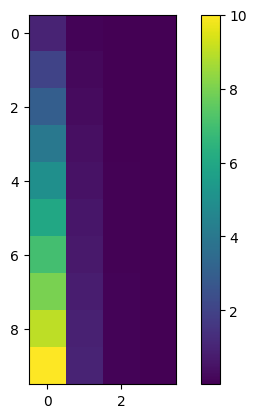

In [ ]:
dq = 8
halfdq = int(dq/2)
maxlen = 10
THETA = 10000

import math
S = math.pow(THETA,-2/dq)
print(S)

thetas = [[i * math.pow(S,k-1) for k in range(1,halfdq+1)] for i in range(1,maxlen+1)]



import matplotlib.pyplot as plt
import numpy as np
thetas = np.array(thetas)

np.set_printoptions(precision=3, suppress=True)
print(thetas)
plt.imshow(thetas)
plt.colorbar()
plt.show()


In [17]:
itorch = torch.arange(1,maxlen+1)
print(itorch)
print(itorch.dtype, itorch.shape)
rearrange(itorch,"seq -> seq 1")
print(itorch)
print(itorch.shape)

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
torch.int64 torch.Size([10])
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
torch.Size([10])


In [19]:
ktorch = S ** torch.arange(halfdq)
thetastorch = einsum(itorch,ktorch,"seq, dimq -> seq dimq")
print(thetastorch)

tensor([[1.0000e+00, 1.0000e-01, 1.0000e-02, 1.0000e-03],
        [2.0000e+00, 2.0000e-01, 2.0000e-02, 2.0000e-03],
        [3.0000e+00, 3.0000e-01, 3.0000e-02, 3.0000e-03],
        [4.0000e+00, 4.0000e-01, 4.0000e-02, 4.0000e-03],
        [5.0000e+00, 5.0000e-01, 5.0000e-02, 5.0000e-03],
        [6.0000e+00, 6.0000e-01, 6.0000e-02, 6.0000e-03],
        [7.0000e+00, 7.0000e-01, 7.0000e-02, 7.0000e-03],
        [8.0000e+00, 8.0000e-01, 8.0000e-02, 8.0000e-03],
        [9.0000e+00, 9.0000e-01, 9.0000e-02, 9.0000e-03],
        [1.0000e+01, 1.0000e+00, 1.0000e-01, 1.0000e-02]])
